In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [7]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [8]:
#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)

In [6]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [7]:
from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

In [9]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


In [20]:
print(msvds[sid].injections[0].max())
print(msvds[sid].experiments[158375425].normalized_injection_density.max())
print(msvds[sid].experiments[158375425].normalized_projection_density.max())

0.014824019
0.014824019
0.014824019


In [ ]:
msvds[sid].projections.shape

In [30]:
f = msvds[sid].experiments[158375425].normalized_injection_density.flatten()

f[(-f).argsort()[:100]]

array([0.01482402, 0.01482402, 0.01482402, 0.01482402, 0.01482402,
       0.01482402, 0.014824  , 0.014824  , 0.01482358, 0.01482354,
       0.01482337, 0.01482317, 0.01482153, 0.01482128, 0.01482113,
       0.0148182 , 0.01479605, 0.01477092, 0.01473529, 0.01461815,
       0.0144208 , 0.01440432, 0.01439965, 0.01427967, 0.01427365,
       0.0141869 , 0.01414015, 0.0141065 , 0.014013  , 0.01399387,
       0.01389438, 0.01383889, 0.01369558, 0.01348166, 0.01329456,
       0.01309735, 0.01293912, 0.01276745, 0.01240593, 0.01211337,
       0.01196711, 0.0116852 , 0.01143902, 0.01107775, 0.01085161,
       0.01076496, 0.00991752, 0.00916911, 0.00909889, 0.00861501,
       0.00859667, 0.00835598, 0.00800152, 0.00756765, 0.00753425,
       0.00739819, 0.00735303, 0.00707361, 0.00703259, 0.00632085,
       0.0062665 , 0.00626603, 0.00600565, 0.00591985, 0.0059169 ,
       0.00552637, 0.00549334, 0.00544549, 0.00522373, 0.00490596,
       0.00488928, 0.00466487, 0.00454742, 0.00452757, 0.00441

In [ ]:
    #first we get the experiment
    #this calls from_cache
    #experiment.from_cache populates injection and projection density as follows
    #the injection fraction (the fraction of injection in that voxel) is applied
    #this appears to be done twice for some reason
    #the data quality mask is applied
    #

In [58]:
#msvds[sid].experiments[158375425].projection_density = cache.get_projection(158375425)[0] then 2x masking
me1pd = cache.get_projection_density(158375425)[0]
print(msvds[sid].experiments[158375425].projection_density.mean())
print(me1pd.mean())
#it looks like the data quality mask and injection fraction were never applied
print(msvds[sid].projections.shape)
#msvds[sid].experiments[158375425].injection_density = cache.get_injection(158375425)[0]
me1id = cache.get_injection_density(158375425)[0]
print(msvds[sid].experiments[158375425].injection_density.mean(), me1id.mean())
#msvds[sid].experiments[158375425].normalized_projection_density
#msvds[sid].experiments[158375425].normalized_injection_density
#cache.get_injection_fraction(158375425)[0]
#msvds[sid].injections
#msvds[sid].projections
#

0.0012177202
0.0012177569
(83, 448962)
5.6035762e-05 7.520556e-05


In [80]:
help(cache.get_injection_fraction)

Help on method get_injection_fraction in module allensdk.core.mouse_connectivity_cache:

get_injection_fraction(experiment_id, file_name=None) method of mcmodels.core.voxel_model_cache.VoxelModelCache instance
    Read an injection fraction volume for a single experiment. Download it
    first if it doesn't exist.  Injection fraction is the proportion of
    pixels in the injection site in a grid voxel in [0,1].
    
    Parameters
    ----------
    
    experiment_id: int
        ID of the experiment to download/read.  This corresponds to
        section_data_set_id in the API.
    
    file_name: string
        File name to store the template volume.  If it already exists,
        it will be read from this file.  If file_name is None, the
        file_name will be pulled out of the manifest.  Default is None.



In [95]:
injection_fraction = data_volumes["injection_fraction"]

In [76]:
    
        data_volumes = _pull_grid_data(cache, 158375425)
#         except AttributeError:
#             raise ValueError('cache must be a MouseConnectivityCache or '
#                              'VoxelModelCache object, not %s' % type(cache))
        print(np.mean(data_volumes["projection_density"]),'p')
        print(np.mean(data_volumes["injection_density"]),'i')
        # compute 'true' injection density (inplace)
        _compute_true_injection_density(data_volumes["injection_density"],
                                        data_volumes["injection_fraction"],
                                        inplace=True)
        #this did change the injection density
        print(np.mean(data_volumes["injection_density"]),'i')
        # mask data in place
        mask_func = partial(_mask_data_volume,
                            data_mask=data_volumes["data_mask"],
                            tolerance=data_mask_tolerance)

        injection_density = mask_func(data_volumes["injection_density"])
        projection_density = mask_func(data_volumes["projection_density"])
        print(np.mean(data_volumes["injection_density"]),'i')
        print(np.mean(data_volumes["projection_density"]),'p')
        print(np.mean(injection_density),'i')
        print(np.mean(projection_density),'p')     
#     if inplace:
#         np.multiply(injection_density, injection_fraction, injection_density)
#         return injection_density

#     return np.multiply(injection_density, injection_fraction)


0.0012177569 p
7.520556e-05 i
5.6035762e-05 i
5.6035762e-05 i
0.0012177202 p
5.6035762e-05 i
0.0012177202 p


In [73]:
ad = data_volumes["data_mask"] * data_volumes["injection_density"]
sf = data_volumes["data_mask"] * data_volumes["projection_density"]

In [75]:
(data_volumes["injection_density"] - ad).max()
(data_volumes["projection_density"] - sf).max()

0.0030314825

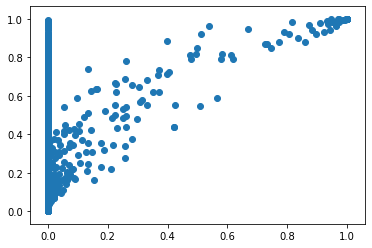

In [82]:
plt.scatter(injection_density, projection_density)

In [98]:
np.where(injection_fraction == 1.)

(array([70, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72]),
 array([42, 41, 42, 42, 43, 43, 41, 42, 42, 42, 43, 43, 43]),
 array([77, 76, 76, 77, 76, 77, 76, 75, 76, 77, 75, 76, 77]))

In [91]:
nnnn = np.asarray(np.where(injection_density == projection_density))

In [92]:
mmm = np.asarray(np.where(injection_density != 0.))

In [99]:
injection_density[70,42,77]

0.999815

In [100]:
projection_density[70,42,77]

0.999815

In [101]:
#def apply_inj_fraction(data_volumes["injection_density"],data_volumes["injection_fraction"]):
data_volumes = _pull_grid_data(cache, 158375425)
    
projection_density = data_volumes["projection_density"]

projection_density_qmask = projection_density * data_volumes["data_mask"]
injection_density_qmask = data_volumes["injection_density"] * data_volumes["data_mask"]

projection_fraction = 1 - data_volumes["injection_fraction"]

projection_density_fraction = projection_density_qmask * projection_fraction
injection_density_fraction = injection_density_qmask * injection_fraction

injection_volume = injection_density_fraction.sum()

#3 different norms
projection_density_totalnorm = projection_density_qmask / projection_density_qmask.sum()
projection_density_fractionnorm = projection_density_fraction / projection_density_fraction.sum()
projection_density_fraction_ivnorm = projection_density_fraction / injection_volume

#if i average
#np.sum(injection_density_fraction)
#def apply_proj_fraction(projection_density,projection_fraction):

In [133]:
projection_density.sum()


1465.9845

How does normalization change before and after injection.  Instead of mean 1/nvox Constant multiplier nvox / nsum so mean 1/nsum

In [13]:
from mcmodels.core.utils import get_injection_hemisphere_id ,compute_centroid# get_injection_hemisphere_id

In [14]:
    #msvd2 = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)

    voxel_data = ModelData(cache, sid)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))
    experiments = {}
    # print('h')

    # experiment
    injection_mask = Mask.from_cache(
        cache,
        structure_ids=[sid],
        hemisphere_id=2)
    projection_mask = Mask.from_cache(
        cache,
        structure_ids=default_structure_ids,
        hemisphere_id=3)

    #first we get the experiment
    #experiment.from_cache populates injection and projection density
    for eid in experiment_ids[:1]:
        # print(eid)
        experiments[eid] = get_experiment(cache, eid, sid,default_structure_ids)
        experiments[eid].projection_mask = projection_mask
        experiments[eid].injection_mask = injection_mask

    #then we get the matrices... uses experiment.get_injection and .get_projection
    VDs = VoxelDataset()
    VDs.sid = sid
    VDs.projection_mask = projection_mask
    VDs.injection_mask = injection_mask
    VDs.experiments = experiments
    VDs.centroids, VDs.injections, VDs.projections = get_matrices(experiments)
    
    experiment = experiments[eid]
    projection = experiment.get_projection(True)
    #True means normalized by injection volume
    
    #return experiment.projection_mask.mask_volume(projection)

In [19]:
experiments[eid].projection_density.shape
projection = experiments[eid].get_projection(True)
projection.shape

(132, 80, 114)

In [16]:
VDs.projections.shape

(1, 448962)

In [142]:
experiment.projection_density.shape, experiment.projection_density.sum()

((132, 80, 114), 1465.9403)

In [145]:
(experiment.projection_density / experiment.injection_density.sum()).sum()

21.73112

In [141]:
print(projection.shape, projection.sum())
experiment.projection_mask.mask_volume(projection).sum()
msvds[sid].projections[0].sum()
experiments[eid].projection_density.sum()
VDs.projections[0].sum()

(132, 80, 114) 21.73112


18.502546

18.502546

1465.9403

18.502546

In [ ]:
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

In [ ]:
# def get_regionalized_normalized_data(msvds, cache, source_order, ipsi_key, contra_key): #experiments_minor_structures):
#     '''

#     :param msvds: Class dictionary holding data
#     :param cache: AllenSDK cache
#     :param source_order: Source key (tautologically ipsilateral due to hemisphere mirroring)
#     :param ipsi_key: Ipsilateral target key
#     :param contra_key:  Contralateral target key
#     :return: msvds: Class dictionary holding average data
#     '''
#     major_structure_ids = np.asarray(list(msvds.keys()))
#     for sid in major_structure_ids:
#         # print()
#         msvd = msvds[sid]
#         #nexp = msvd.projections.shape[0]

#         #minor_structures = np.unique(experiments_minor_structures[sid])
#         #nmins = len(minor_structures)

#         projections = msvd.projections
#         ipsi_proj = unionize(projections, ipsi_key)
#         contra_proj = unionize(projections, contra_key)
#         reg_proj = np.hstack([ipsi_proj, contra_proj])
#         msvd.reg_proj = reg_proj

#         ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
#         contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
#         target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
#         reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
#         msvd.reg_proj_vcount_norm = reg_proj_vcount_norm

#         projections = msvds[sid].reg_proj_vcount_norm
#         projections = projections / np.expand_dims(np.linalg.norm(projections, axis=1), 1)
#         msvd.reg_proj_vcount_norm_renorm = projections

#         source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
#         source_key = source_mask.get_key(structure_ids=source_order)
#         source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

#         injections = msvd.injections
#         reg_ipsi_inj = unionize(injections, source_key)
#         msvd.reg_inj = reg_ipsi_inj
#         reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_counts[np.newaxis, :])
#         msvd.reg_inj_vcount_norm = reg_inj_vcount_norm
#         #msvd.reg_proj_vcountnorm_totalnorm =

#     return (msvds)


In [112]:
msvds[sid].projections[0].sum()

18.502546

In [129]:
msvds[sid].projections[0].sum()

18.502546

In [79]:
np.max(data_volumes["projection_density"] - projection_density)

0.0

In [78]:
np.mean(projection_density)

0.0012177202

In [65]:
data_mask_tolerance = .5

In [44]:
#msvds[sid].experiments[158375425].projection_density
#msvds[sid].experiments[158375425].injection_density
#msvds[sid].experiments[158375425].normalized_projection_density
#msvds[sid].experiments[158375425].normalized_injection_density
#cache.get_injection_fraction(158375425)[0]
#msvds[sid].injections
#msvds[sid].projections
#

In [45]:
np.linalg.norm(msvds[sid].injections[0])

0.10287795

In [46]:
np.linalg.norm(msvds[sid].reg_inj[0])

0.8505939481321954

In [47]:
np.linalg.norm(msvds[sid].reg_inj_vcount_norm[0])

0.001054379788852348

In [31]:
np.linalg.norm(msvds[sid].experiments[158375425].normalized_projection_density)

0.289829

In [32]:
np.sum(msvds[sid].experiments[158375425].normalized_projection_density)

21.73112

In [33]:
np.sum(msvds[sid].experiments[158375425].normalized_injection_density)

0.99999994

In [ ]:
msvds[sid].experiments[158375425].inj

In [39]:
iff = cache.get_injection_fraction(158375425)[0].flatten()

In [41]:
iff[(-iff).argsort()[:100]] #1s are pure injection

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.9999253 , 0.9999054 ,
       0.9998701 , 0.9998542 , 0.9993798 , 0.99913156, 0.9984164 ,
       0.9982201 , 0.99663717, 0.9946718 , 0.9943594 , 0.9911197 ,
       0.986306  , 0.98565215, 0.98516786, 0.97889596, 0.97866213,
       0.97827446, 0.97800606, 0.97560865, 0.9755189 , 0.9722624 ,
       0.972062  , 0.96774465, 0.96712893, 0.96212596, 0.9618866 ,
       0.95870984, 0.9542384 , 0.9524523 , 0.9515959 , 0.9422569 ,
       0.9404292 , 0.9167763 , 0.9135634 , 0.90570956, 0.895434  ,
       0.889057  , 0.8887917 , 0.865997  , 0.8384291 , 0.833697  ,
       0.8191063 , 0.8186332 , 0.8092499 , 0.8038596 , 0.7821166 ,
       0.7725507 , 0.77009165, 0.74599046, 0.73576975, 0.72068024,
       0.7151276 , 0.71449214, 0.71302   , 0.71114266, 0.69442797,
       0.6942083 , 0.69270736, 0.6880603 , 0.68774694, 0.67067

In [29]:
f = msvds[sid].experiments[158375425].normalized_projection_density.flatten()

f[(-f).argsort()[:100]]

array([0.01482402, 0.01482402, 0.01482402, 0.01482402, 0.01482402,
       0.01482402, 0.014824  , 0.014824  , 0.0148239 , 0.01482371,
       0.01482366, 0.01482358, 0.01482354, 0.01482337, 0.01482317,
       0.01482128, 0.01482037, 0.01481794, 0.01481472, 0.01481092,
       0.01478046, 0.01477379, 0.01472335, 0.01470718, 0.01469148,
       0.01468396, 0.01463215, 0.01462262, 0.01459919, 0.01457392,
       0.01457286, 0.01456441, 0.01454966, 0.01451585, 0.01448661,
       0.014485  , 0.01440875, 0.01440537, 0.01438777, 0.01438359,
       0.01437753, 0.01437191, 0.01437118, 0.01433918, 0.01432501,
       0.01432205, 0.01429656, 0.01428911, 0.01419288, 0.01417251,
       0.01404433, 0.01401236, 0.01399656, 0.01395361, 0.01395334,
       0.01384482, 0.01380048, 0.01375509, 0.01368901, 0.01368845,
       0.01367134, 0.01365377, 0.01364593, 0.01362403, 0.01357346,
       0.01341364, 0.01337925, 0.01337183, 0.01333569, 0.01330306,
       0.01327948, 0.01325482, 0.01324988, 0.013244  , 0.01321

In [23]:
msvds[sid].experiments[158375425].normalized_projection_density[]

array([[[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0.

In [11]:
"""
Module containing Experiment object and supporting functions.
"""
# Authors: Joseph Knox <josephk@alleninstitute.org>
# License: Allen Institute Software License

from __future__ import division
from functools import partial

import numpy as np

#from .utils import compute_centroid, get_injection_hemisphere_id

#from .model_data import ModelData #.model_data import ModelData
#from .masks import Mask
#from .utils import compute_centroid, get_injection_hemisphere_id
#from .utils import get_matrices


class VoxelDataset:
    """

    Parameters
    ----------
    sid: structure id

    Notes
    _____
    This class holds a collection of experiments in a particular structure
    """
    def __init__(self):#, sid):
        pass
        #self.sid = sid

def get_centroid(experiment):
    """Returns experiment centroid"""
    return experiment.centroid

def get_injection(experiment, normalized_injection):
    # print('ts',experiment.normalized_injection)
    """Returns experiment injection masked & flattened"""
    injection = experiment.get_injection(normalized_injection)
    return experiment.injection_mask.mask_volume(injection)

def get_projection(experiment, normalized_projection):
    """Returns experiment projection masked & flattened"""
    projection = experiment.get_projection(normalized_projection)
    return experiment.projection_mask.mask_volume(projection)

def yield_experiments(experiments):
    ev = experiments.values()
    keys = np.asarray(list(experiments.keys()))
    for i in range(len(keys)):
        yield (experiments[keys[i]])

def get_matrices(experiments):
    get_data = lambda x: (get_centroid(x),
                          get_injection(x,True),
                          get_projection(x, True))
    arrays = map(get_data, yield_experiments(experiments))
    centroids, injections, projections = map(np.array, zip(*arrays))
    return(centroids, injections, projections)


def get_experiment(cache, eid,sid,default_structure_ids):
    experiment = Experiment.from_cache(cache, eid)
    hemisphere_id = experiment.injection_hemisphere_id
    if hemisphere_id == 1:
        experiment = experiment.flip()
#     if (experiment.injection_hemisphere_id == 3 or hemisphere_id == experiment.injection_hemisphere_id):
#        experiment = experiment
#     elif experiment.flip_experiments:
#        experiment = experiment.flip()

    experiment.injection_structure_ids = [sid]
    experiment.major_structure = sid
    experiment.projection_structure_ids = default_structure_ids
    experiment.projection_hemisphere_id = 3
    experiment.normalized_injection = True
    experiment.normalized_projection = True
    return (experiment)

def get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre):
    '''

    :param cache:
    :param sid:
    :param experiments_exclude:
    :param default_structure_ids:
    :param cre:
    :return:
    '''
    voxel_data = ModelData(cache, sid)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))
    experiments = {}
    # print('h')

    # experiment
    injection_mask = Mask.from_cache(
        cache,
        structure_ids=[sid],
        hemisphere_id=2)
    projection_mask = Mask.from_cache(
        cache,
        structure_ids=default_structure_ids,
        hemisphere_id=3)

    #first we get the experiment
    #this calls from_cache
    #experiment.from_cache populates injection and projection density as follows
    #the injection fraction (the fraction of injection in that voxel) is applied
    #this appears to be done twice for some reason
    #the data quality mask is applied
    #
    
#                 data_volumes = _pull_grid_data(cache, experiment_id)
#         except AttributeError:
#             raise ValueError('cache must be a MouseConnectivityCache or '
#                              'VoxelModelCache object, not %s' % type(cache))

#         # compute 'true' injection density (inplace)
#         _compute_true_injection_density(data_volumes["injection_density"],
#                                         data_volumes["injection_fraction"],
#                                         inplace=True)

#         # mask data in place
#         mask_func = partial(_mask_data_volume,
#                             data_mask=data_volumes["data_mask"],
#                             tolerance=data_mask_tolerance)

#         injection_density = mask_func(data_volumes["injection_density"])
#         projection_density = mask_func(data_volumes["projection_density"])

#     if inplace:
#         np.multiply(injection_density, injection_fraction, injection_density)
#         return injection_density

#     return np.multiply(injection_density, injection_fraction)

    for eid in experiment_ids:
        # print(eid)
        experiments[eid] = get_experiment(cache, eid, sid,default_structure_ids)
        experiments[eid].projection_mask = projection_mask
        experiments[eid].injection_mask = injection_mask

    #then we get the matrices... uses experiment.get_injection and .get_projection
    #self.injection_density / self.injection_volume
    VDs = VoxelDataset()
    VDs.sid = sid
    VDs.projection_mask = projection_mask
    VDs.injection_mask = injection_mask
    VDs.experiments = experiments
    VDs.centroids, VDs.injections, VDs.projections = get_matrices(experiments)
    return (VDs)

def _pull_grid_data(cache, experiment_id):
    """Pulls data volumes using VoxelModelCache object.

    Parameters
    ----------
    cache : VoxelModelCache or MouseConnectivityCache instance.
        Object used to pull grid data.

    experiment_id : int
        Experiment id of the experiment from which to pull grid data.

    Returns
    -------
    dict
        Container of relevant data volumes.
        See allensdk.core.mouse_connectivity_cache for description of volumes.

    Notes
    -----
    voxel_model_cache.get_<data_volume> returns a tuple (data_volume, meta_data).
    We only care about the data volume.

    """
    return {
        "data_mask" : cache.get_data_mask(experiment_id)[0],
        "injection_density" : cache.get_injection_density(experiment_id)[0],
        "injection_fraction" : cache.get_injection_fraction(experiment_id)[0],
        "projection_density" : cache.get_projection_density(experiment_id)[0]
    }


def _mask_data_volume(data_volume, data_mask, tolerance=0.0):
    """Masks a given data volume in place.

    Parameters
    ----------
    data_volume : array, shape (x_ccf, y_ccf, z_ccf)
        Data volume to be masked.

    data_mask : array, shape (x_ccf, y_ccf, z_ccf)
        data_mask for given experiment (values in [0,1])
        See allensdk.core.mouse_connectivity_cache for more info.

    tolerance : float, optional (default=0.0)
        tolerance with which to define bad voxels in data_mask.


    Returns
    -------
    data_volume
        data_volume parameter masked in place.

    """
    if data_volume.shape != data_mask.shape:
        raise ValueError("data_volume (%s) and data_mask (%s) must be the same "
                         "shape!" % (data_volume.shape, data_mask.shape))

    # mask data volume
    data_volume[data_mask < tolerance] = 0.0

    return data_volume


def _compute_true_injection_density(injection_density, injection_fraction, inplace=False):
    """Computes 'true' injection_density.

    Takes into consideration injection fracion (proportion of pixels in the
    annotated injection site).

    Parameters
    ----------
    injection_density : array, shape (x_ccf, y_ccf, z_ccf)
        injection_density data volume.

    injection_fraction : array, shape (x_ccf, y_ccf, z_ccf)
        injection_fraction data volume.

    inplace : boolean
        If True, overwrites injection_density parameter, else returns new array.

    Returns
    -------
    array, shape (x_ccf, y_ccf, z_ccf)
        'true' injection density : injection_density * injection_fraction
    """
    if injection_density.shape != injection_fraction.shape:
        raise ValueError("injection_density (%s) and injection_fraction "
                         "(%s) must be the same shape!"
                         % (injection_density.shape, injection_fraction.shape))

    if inplace:
        np.multiply(injection_density, injection_fraction, injection_density)
        return injection_density

    return np.multiply(injection_density, injection_fraction)


class Experiment(object):
    """Class containing the data from an anterograde injection

    Experiment conveniently compiles the relevant information from a given
    anterograde viral tracing experiment data.

    Parameters
    ----------
    voxel_model_cache : VoxelModelCache object
        This supplies the interface for pulling experimental data.

    experiment_id : int
        AllenSDK id assigned to given experiment

    Examples
    --------
    >>> from mcmodels.core import Experiment, VoxelModelCache
    >>> cache = VoxelModelCache()
    >>> eid = 100141273
    >>> exp = Experiment(voxel_model_cache, eid)
    >>> exp.injection_density.shape
    (132,80,114)
    """

    DEFAULT_DATA_MASK_TOLERANCE = 0.5

    @classmethod
    def from_cache(cls, cache, experiment_id, data_mask_tolerance=None):
        """Alternative constructor allowing for pulling grid data.

        Parameters
        ----------
        cache : VoxelModelCache or MouseConnectivityCache instance.
            Object used to pull grid data.

        experiment_id : int
            Experiment id of the experiment from which to pull grid data.

        data_mask_tolerance : float, optional (default = None)
            Tolerance with which to mask 'bad' data. data_mask array has values
            on the interval [0,1], where a nonzero element indicates a 'bad'
            voxel. If None is passed, the parameter defaults to
            DEFAULT_DATA_MASK_TOLERANCE (0.5).
        """
        if data_mask_tolerance is None:
            data_mask_tolerance = cls.DEFAULT_DATA_MASK_TOLERANCE

        try:
            # pull data
            data_volumes = _pull_grid_data(cache, experiment_id)
        except AttributeError:
            raise ValueError('cache must be a MouseConnectivityCache or '
                             'VoxelModelCache object, not %s' % type(cache))

        # compute 'true' injection density (inplace)
        _compute_true_injection_density(data_volumes["injection_density"],
                                        data_volumes["injection_fraction"],
                                        inplace=True)

        # mask data in place
        mask_func = partial(_mask_data_volume,
                            data_mask=data_volumes["data_mask"],
                            tolerance=data_mask_tolerance)

        injection_density = mask_func(data_volumes["injection_density"])
        projection_density = mask_func(data_volumes["projection_density"])

        return cls(injection_density, projection_density)


    def __init__(self, injection_density=None, projection_density=None):
        # assume numpy array
        if injection_density.shape != projection_density.shape:
            raise ValueError("injection_density (%s) and projection_density "
                             "(%s) must be the same shape!"
                             % (injection_density.shape, projection_density.shape))

        self.injection_density = injection_density
        self.projection_density = projection_density

    def __repr__(self):
        return '{0}(volume_shape={1})'.format(
            self.__class__.__name__, self.injection_density.shape)

    @property
    def injection_hemisphere_id(self):
        """Returns injection hemisphere"""
        return get_injection_hemisphere_id(self.injection_density, majority=True)

    @property
    def bilateral_injection(self):
        """Returns injection hemisphere"""
        return get_injection_hemisphere_id(self.injection_density) == 3

    @property
    def injection_volume(self):
        """Returns total injection volume = sum(injection_density)"""
        return self.injection_density.sum()

    @property
    def projection_volume(self):
        """Returns total projection volume = sum(projection_density)"""
        return self.projection_density.sum()

    @property
    def centroid(self):
        """Returns centroid of the injection density."""
        return compute_centroid(self.injection_density)

    @property
    def normalized_injection_density(self):
        """Returns injection density normalized to have unit sum."""
        return self.injection_density / self.injection_volume

    @property
    def normalized_projection_density(self):
        """Returns projection_density normalized by the total injection_density"""
        return self.projection_density / self.injection_volume

    def get_injection(self, normalized=False):
        if normalized:
            return self.normalized_injection_density
        return self.injection_density

    def get_projection(self, normalized=False):
        if normalized:
            return self.normalized_projection_density
        return self.projection_density

    def flip(self):
        """Reflects experiment along midline.

        Returns
        -------
        self - flipped experiment
        """
        self.injection_density = self.injection_density[..., ::-1]
        self.projection_density = self.projection_density[..., ::-1]

        return self
